<a href="https://colab.research.google.com/github/whyzhuce/XConparraison/blob/master/Local_vol_calibration_and_Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Volatilité locale (Dupire) : calibration et Monte Carlo
---


> **Antonin Chaix**


Le but de ce TP est de d'implémenter un modèle à volatilité locale à partir d'une surface de vol implicite de marché donnée par le modèle SABR (term structure de paramètres SABR interpolée en temps par des splines cubiques).

## Le modèle

Le modèle est donné par l'EDS suivante, sous la mesure risque-neutre :

$$
\frac{dS_t}{S_t}=\mu(t)dt+\sigma(t,S_t)dW_t
$$

où le drift déterministe $\mu(t)$  est inféré à partir de la term-structure des forwards sur l'actif $S$ (considérée comme un input). Ainsi, la fonction $\mu$ constante par morceaux pourra être déterminée grâce à la relation suivante :

$$
F_0(T) = S_0\exp\left(\int_0^T \mu(s)ds\right)
$$

où $F_0(T)$ représente à l'instant $t=0$ le forward de maturité $T$ sur l'actif $S$.

La formule de Dupire nous donne explicitement la fonction de volatilité locale $\sigma$ à partir de la nappe de volatilité implicite $\hat\sigma$, dès lors que celle-ci est suffisamment régulière (continuement dérivable une fois par rapport $T$ et deux fois par rapport à $K$). C'est ce qui fait la force et le succès du modèle à volatilité locale : dès lors que l'on a créé par interpolation une belle nappe de volatilité implicite, on connaît explicitement la volatilité locale $\sigma$ qui calibre le modèle sur ces volatilités implicites.

La formule de Dupire donnant la vol locale $\sigma$ en fonction de la vol implicite $\hat\sigma$ est la suivante :

$$
\sigma^2(T,K)=\frac{2\frac{\partial \hat\sigma}{\partial T}+\frac{\hat\sigma}{T}+2K\mu(T)\frac{\partial \hat\sigma}{\partial K}}
{K^2\left[\frac{\partial^2 \hat\sigma}{\partial K^2}-d_1\sqrt{T}\left(\frac{\partial \hat\sigma}{\partial K}\right)^2+\frac{1}{\hat\sigma
}\left(\frac{1}{K\sqrt{T}}+d_1\frac{\partial \hat\sigma}{\partial K}\right)^2\right]}\\
$$
avec
$$
d_1=\frac{\ln(S_0/K)+\int_0^T\mu(s)ds}{\hat\sigma\sqrt{T}}
+ \frac{1}{2}\hat\sigma\sqrt{T}
$$

<br>**NB** : bien noter le caractère muet des variables $T$ et $K$ (ou plus exactement la dualité entre les variables $(T,K)$ et $(t,S_t)$). Concrétement, pour calculer la volatilité locale au point $(t, S_t)$ (dans un Monte Carlo par exemple), on évaluera donc :

$$
\sigma^2(t,S_t)=\frac{2\frac{\partial \hat\sigma}{\partial T}(t,S_t)+\frac{\hat\sigma(t,S_t)}{t}+2S_t\mu(t)\frac{\partial \hat\sigma}{\partial K}(t,S_t)}
{S_t^2\left[\frac{\partial^2 \hat\sigma}{\partial K^2}(t,S_t)-d_1\sqrt{t}\left(\frac{\partial \hat\sigma}{\partial K}(t,S_t)\right)^2+\frac{1}{\hat\sigma(t,S_t)
}\left(\frac{1}{S_t\sqrt{t}}+d_1\frac{\partial \hat\sigma}{\partial K}(t,S_t)\right)^2\right]}\\
$$
avec
$$
d_1=\frac{\ln(S_0/S_t)+\int_0^t\mu(s)ds}{\hat\sigma(t,S_t)\sqrt{t}}
+ \frac{1}{2}\hat\sigma(t,S_t)\sqrt{t}
$$


## La courbe des taux

On se donne la courbe zéro-coupon en interpolant ses piliers avec des splines cubiques et on définit quelques fonctions utiles pour la suite...

In [ ]:
import numpy as np
import math
from scipy.interpolate import interp1d

# yield curve (zero rates)
yc_maturities = np.array([0, 1, 2, 5, 10, 15, 20, 30])
yc_zc_rates = np.array([-0.55, -0.52, -0.51, -0.4,  -0.18,  0.02,  0.11,  0.09]) * 0.01
yc_zc_rates_interp = interp1d(yc_maturities, yc_zc_rates, kind='cubic', fill_value="extrapolate")

def zc_rate(T) :
    return yc_zc_rates_interp(T)

def DF(T) :
    return math.exp(-yc_zc_rates_interp(T)*T)

Voyons voir à quoi ressemble notre courbe ZC :


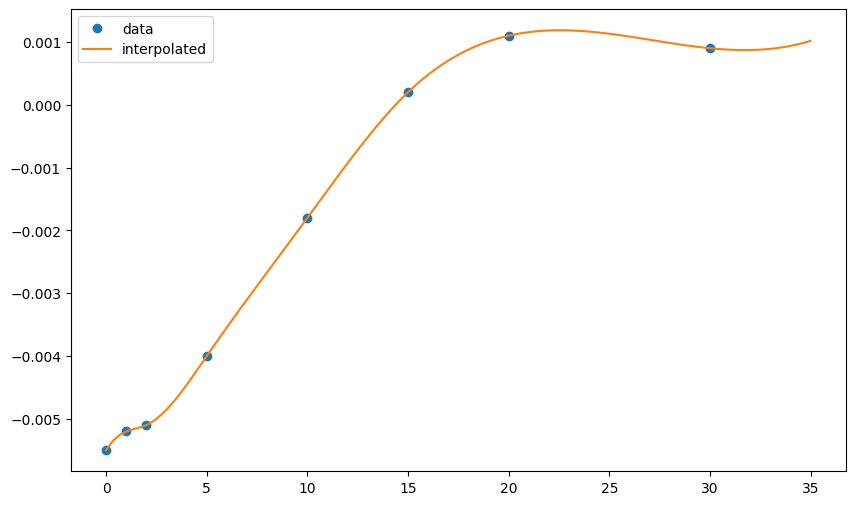

In [ ]:
# plot zc curve
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
maturities = np.linspace(0, 35, num=101, endpoint=True)
plt.plot(yc_maturities, yc_zc_rates, 'o', maturities, zc_rate(maturities))
plt.legend(['data', 'interpolated'], loc='best')
plt.show()

## Le sous-jacent

On définit ici les term-structures :

* des forwards
* des paramètres SABR permettant de construire la nappe de vol

In [ ]:
# underlying params
S0 = 100
S_maturities = np.array([0.08, 0.25, 0.50, 1.00, 1.50, 2.00])
S_forwards = np.array([99.9563, 99.8655, 99.7354, 99.4813, 99.2301, 98.9851])  # généré sans dividendes avec s_forwards = S0 * np.exp(zc_rate(s_maturities)*s_maturities)
S_sigma0 = np.array([20.0, 18.5, 17.4, 16.5, 15.5, 14.5]) * 0.01
S_alpha = np.array([95, 80, 70, 60, 50, 40]) * 0.01
S_rho = np.array([-0.4, -0.35, -0.3, -0.3, -0.3, -0.3])
S_beta = np.full(6, 1.)

# implied vol : cubic spline interp on sabr params
S_forwards_interp = interp1d(S_maturities, S_forwards, kind='cubic', fill_value="extrapolate")
S_sigma0_interp = interp1d(S_maturities, S_sigma0, kind='cubic', fill_value="extrapolate")
S_alpha_interp = interp1d(S_maturities, S_alpha, kind='cubic', fill_value="extrapolate")
S_rho_interp = interp1d(S_maturities, S_rho, kind='cubic', fill_value="extrapolate")
S_beta_interp = interp1d(S_maturities, S_beta, kind='cubic', fill_value="extrapolate")

#plot sabr params across time
# t = np.linspace(0,2, 101, endpoint=True)
# plt.plot(t, S_sigma0_interp(t))
# plt.show()


Il nous faut bien sûr la fonction SABR pour travailler...

In [ ]:
# SABR lognormal vol formula from [https://github.com/ynouri/pysabr] made numpy compatible
def sabr_vol (T, K, F0, sigma0, alpha, rho, beta) :
    """
    Hagan's 2002 SABR lognormal vol expansion.
    The strike K can be a scalar or an array, the function will return an array
    of lognormal vols.
    """
    eps = 1e-07
    logfk = np.log(F0 / K)
    fkbeta = (F0*K)**(1 - beta)
    a = (1 - beta)**2 * sigma0**2 / (24 * fkbeta)
    b = 0.25 * rho * beta * alpha * sigma0 / fkbeta**0.5
    c = (2 - 3*rho**2) * alpha**2 / 24
    d = fkbeta**0.5
    v = (1 - beta)**2 * logfk**2 / 24
    w = (1 - beta)**4 * logfk**4 / 1920
    z = alpha * fkbeta**0.5 * logfk / sigma0
    tmp = sigma0 * (1 + (a + b + c) * T)
    num = np.where(abs(z) > eps, z * tmp, tmp)
    den = np.where(abs(z) > eps, (d * (1 + v + w) * _x(rho, z)), d * (1 + v + w))
    return num / den

def _x(rho, z):
    """Return function x used in Hagan's 2002 SABR lognormal vol expansion."""
    a = (1 - 2*rho*z + z**2)**.5 + z - rho
    b = 1 - rho
    return np.log(a / b)


Ce qui permet de definir notre nappe de volatilité implicite, puis la fonction calculant la volatilité locale à partir de la vol implicite :

In [ ]:
# implied vol : time dependent spline interpolation of SABR parameters
def implied_vol(T, K) :
	F0 = S_forwards_interp(T)
	sigma0 = S_sigma0_interp(T)
	alpha = S_alpha_interp(T)
	rho = S_rho_interp(T)
	beta = S_beta_interp(T)
	return sabr_vol(T, K, F0, sigma0, alpha, rho, beta)

# local vol from Dupire's formula
def local_vol(t, S) :
	t = np.where(t == 0, 1e-08, t) # to avoid divide by 0
	eps_t = 1e-07
	eps_S = eps_t * S
	vol = implied_vol(t, S)
	sqrt_t = np.sqrt(t)
	drift = np.log(S_forwards_interp(t + eps_t) / S_forwards_interp(t)) / eps_t
	dvol_dT = (implied_vol(t + eps_t, S) - vol) / eps_t
	dvol_dK = (implied_vol(t, S + eps_S) - vol) / eps_S
	d2vol_dK2 = (implied_vol(t, S + eps_S) + implied_vol(t, S - eps_S) - 2 * vol ) / eps_S**2
	d1 = (np.log(S0 / S) + np.log(S_forwards_interp(t) / S0) + 0.5 * vol**2 * t) / (vol * sqrt_t)
	num = 2 * dvol_dT + vol / t + 2 * S * drift * dvol_dK
	den = S**2 * (d2vol_dK2 - d1*sqrt_t*dvol_dK**2 + (1/(S*sqrt_t) + d1*dvol_dK)**2 / vol)
	return np.sqrt(np.where(num/den >= 0, num/den, 0))


Voyons voir à quoi ressemble notre vol implicite et notre vol locale...

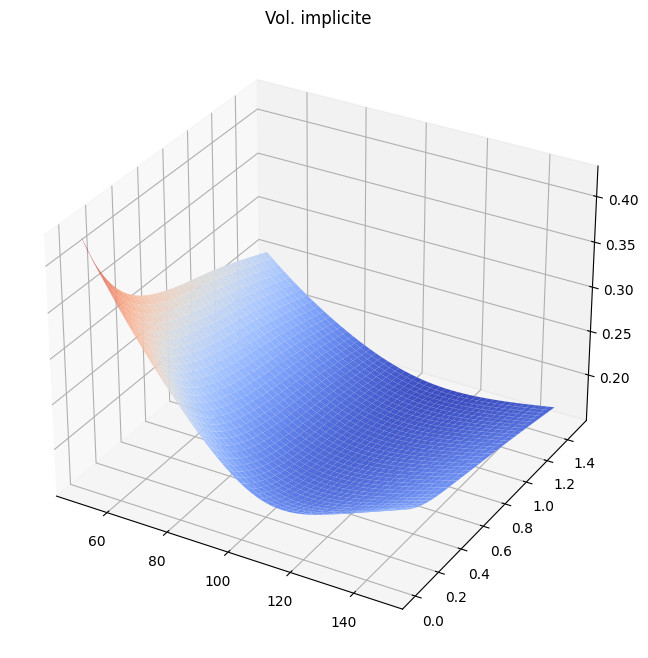

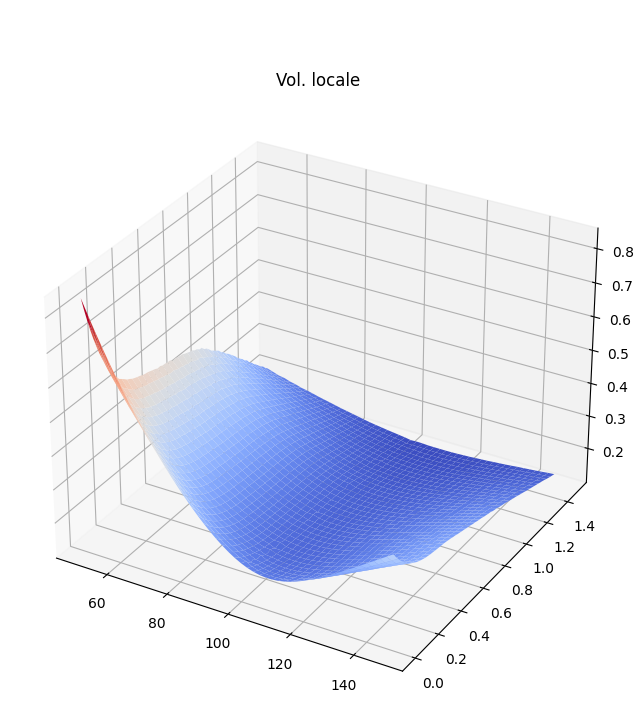

In [ ]:
# plot implied vol or local vol surface
from matplotlib import cm
plt.rcParams["figure.figsize"] = (11,8)

K = np.arange(50, 150, 2)
T = np.arange(0, 1.5, 0.02)
K, T = np.meshgrid(K, T)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
vols = implied_vol(T, K) # vols = local_vol(T, K)
surf = ax.plot_surface(K, T, vols, cmap=cm.coolwarm, linewidth=0, antialiased=True)
plt.title("Vol. implicite")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
vols = local_vol(T, K)
surf = ax.plot_surface(K, T, vols, cmap=cm.coolwarm, linewidth=0, antialiased=True)
plt.title("\n\n\nVol. locale")
plt.show()

## Monte Carlo

L'objectif est d'implémenter un Monte Carlo dans le modèle à vol locale afin :

* de vérifier si les prix obtenus pour des options européennes sont conformes à ceux fournis par la nappe de vol implicite en input
* de pricer une option binaire européenne et de vérifier si le prix obtenu est conforme au pricing par call spread (utilisant les vols implicites)
* de pricer un call barrière down & out



**NB** : dans [ce colab](https://colab.research.google.com/drive/190FfBc0w-fz8vim3x7RrFcb_Tu-Px2Hu?usp=sharing), vous trouverez l'implémentation du schéma de différences finies dans le même modèle à volatilité locale. Dès que cela est possible (option pas "trop" path-dependent), cette solution est à privilégier par rapport au Monte Carlo (temps de calcul beaucoup plus faible, et résultats plus précis !)

### Simulation des trajectoires de l'actif

In [ ]:
# MC params
T = 1 # horizon de simulation = maturité des options
Nsimul = 10**6
Nsteps = 100

# generate random N(0,1)
normal = np.random.normal(0, 1, (Nsteps, Nsimul))

# time vector
dt = T / Nsteps
t = np.linspace(0, T, num=Nsteps+1, endpoint=True)
sqrt_dt = math.sqrt(dt)

# S array (time x simulations)
S = np.empty(shape=(Nsteps + 1, Nsimul))
S[0,:] = S0

# local vol interpolation params
n_interp = 101
n_stdev = 5
prev_fwd = S0

for j in range(Nsteps) :

	# S points for local vol interpolation computed for each time step (from standard deviation of S)
	fwd = S_forwards_interp(t[j+1])
	factor = math.exp(n_stdev * implied_vol(t[j+1], fwd) * math.sqrt(t[j+1]))
	Smax = fwd * factor
	Smin = fwd / factor
	Sinterp = np.linspace(Smin, Smax, num=n_interp, endpoint=True)

	# compute local vol interpolation
	local_vol_interp = interp1d(Sinterp, local_vol(t[j], Sinterp), kind='cubic', fill_value="extrapolate")

	# vol & drift
	sigma = local_vol_interp(S[j,:]) # interpolation is much faster than sigma = local_vol(t[j], S[j,:])

	mu = math.log(fwd / prev_fwd) / dt
	prev_fwd = fwd

	# main loop on simulations
	S[j+1,:] = S[j,:] * np.exp( (mu - 0.5 * sigma**2) * dt + sigma * sqrt_dt * normal[j,:])

In [ ]:
# Une petite fonction pour calculer le prix Monte Carlo à partir du payoff et afficher l'intervalle de confiance
def compute_and_print_price(payoff, option_name, closed_form_price = -1) :
	price = np.mean(payoff)
	stdev = np.std(payoff)
	IClow = price - 1.96 * stdev / math.sqrt(Nsimul)
	ICup = price + 1.96 * stdev / math.sqrt(Nsimul)
	if (closed_form_price == -1) : print("{} = {:.4f}".format(option_name, price) )
	else : 	print("{} = {:.4f} (closed-form price = {:.4f})".format(option_name, price, closed_form_price) )
	print("IC 95% = [{:.4f} ; {:.4f}]".format(IClow,ICup) )
	print("-----------------------------------------------------")


### Repricing d'un call européen

On vérifie que le prix obtenu dans le Monte Carlo du modèle à vol locale pour un call européen coïncide avec Black-Scholes @ vol implicite...

In [ ]:
from scipy.stats import norm

# BS call function
def bs_call(T, K, F0, sigma) :
	sigma_sqrt_T = sigma * math.sqrt(T)
	d1 = (math.log(F0/K) + 0.5 * sigma**2 * T) / sigma_sqrt_T
	d2 = d1 - sigma_sqrt_T
	return F0 * norm.cdf(d1) - K * norm.cdf(d2)

# call strike
K = 100

# european call payoff
payoff_call_eur = DF(T) * np.maximum(S[-1,:] - K , 0)

# closed form for european call
vol = implied_vol(T, K)
fwd = S_forwards_interp(T)
call_eur =  DF(T) * bs_call(T, K, fwd, vol)

# Pricing du call européen dans le modèle à vol locale
compute_and_print_price(payoff_call_eur, "Call européen", call_eur)


Call européen = 6.4619 (closed-form price = 6.4379)
IC 95% = [6.4412 ; 6.4826]
-----------------------------------------------------


### Pricing d'une binaire européenne

On évalue une option digitale dans le modèle à vol locale et on vérifie que l'on retombe sur le prix obtenu par call spread à partir de la nappe de vol implicite.

In [ ]:
# digital strike - options pays 1 if S(T) > K and 0 otherwise
K = 100

# digital payoff
payoff_binaire = DF(T) * np.where(S[-1,:] > K, 1., 0.)

# closed form for digital option (call spread)
fwd = S_forwards_interp(T)
vol_minus = implied_vol(T, K-1)
vol_plus  = implied_vol(T, K+1)
digital = DF(T) * (bs_call(T, K-1, fwd, vol_minus) - bs_call(T, K+1, fwd, vol_plus)) / 2.

# "naïve" black-scholes price (no skew)
vol = implied_vol(T, K)
digital_bs = DF(T) * (bs_call(T, K-1, fwd, vol) - bs_call(T, K+1, fwd, vol)) / 2.

# compute & display
compute_and_print_price(payoff_binaire, "Binaire", digital)
print("Binaire BS naïve = {:.4f}".format(digital_bs))

Binaire = 0.4919 (closed-form price = 0.4918)
IC 95% = [0.4909 ; 0.4929]
-----------------------------------------------------
Binaire BS naïve = 0.4567


### Pricing d'un call barrière up & in : vol locale vs. BS

On évalue un call up & in dont le payoff est :

$$
(S_T-K)^+\mathbb{1}_{\{\max_{[0,T]}S_t > H\}}
$$

In [ ]:
# call down & out params
K = 100
H = 120

vol_bs = vol = implied_vol(T, K)

# S array (time x simulations) for BS
S_bs = np.empty(shape=(Nsteps + 1, Nsimul))
S_bs[0,:] = S0
prev_fwd = S0

# BS paths
for j in range(Nsteps) :

	# S points for local vol interpolation computed for each time step (from standard deviation of S)
	fwd = S_forwards_interp(t[j+1])
	mu = math.log(fwd / prev_fwd) / dt
	prev_fwd = fwd

	# main loop on simulations
	S_bs[j+1,:] = S_bs[j,:] * np.exp( (mu - 0.5 * vol_bs**2) * dt + vol_bs * sqrt_dt * normal[j,:])


# compute payoff
payoff_call_do = DF(T) * np.where(S.max(axis=0) > H, np.maximum(S[-1,:] - K , 0), 0.)
payoff_call_do_bs = DF(T) * np.where(S_bs.max(axis=0) > H, np.maximum(S_bs[-1,:] - K , 0), 0.)

# price & display
compute_and_print_price(payoff_call_do, "Call up & in - vol locale")
compute_and_print_price(payoff_call_do_bs, "Call up & in - BS")

vol_bs_H_minus = vol = implied_vol(0, H-5)
vol_bs_H_plus = vol = implied_vol(0, H+5)
print("Implied vol @ {:.0f} (T = 0) = {:.4f}".format(H-5,vol_bs_H_minus) )
print("Implied vol @ {:.0f} (T = 0) = {:.4f}".format(H+5,vol_bs_H_plus) )
print("-----------------------------------------------------")
vol_bs_H_minus = vol = implied_vol(T, H-5)
vol_bs_H_plus = vol = implied_vol(T, H+5)
print("Implied vol @ {:.0f} (T = {:.1f}) = {:.4f}".format(H-5, T, vol_bs_H_minus) )
print("Implied vol @ {:.0f} (T = {:.1f}) = {:.4f}".format(H+5, T, vol_bs_H_plus) )


Call up & in - vol locale = 4.4058
IC 95% = [4.3850 ; 4.4265]
-----------------------------------------------------
Call up & in - BS = 4.7130
IC 95% = [4.6920 ; 4.7341]
-----------------------------------------------------
Implied vol @ 115 (T = 0) = 0.1953
Implied vol @ 125 (T = 0) = 0.2028
-----------------------------------------------------
Implied vol @ 115 (T = 1.0) = 0.1624
Implied vol @ 125 (T = 1.0) = 0.1661


La différence de prix entre vol locale et Black & Scholes n'est pas négligeable. Elle s'explique par la présence d'un risque digital au niveau de la barrière H = 120 déclenchant le paiement de l'option. A cet endroit, et tout au long de la vie de l'option, le smile est pentu (en l'occurence croissant), impliquant une différence d'évaluation du risque digital entre BS (pas de smile) et la vol locale (qui intégre cette pente sur la vol implicite).